In [4]:
import pandas as pd
import numpy as np
df = pd.read_csv('cicids2017_cleaned.csv')

In [2]:
# Display dataset info
print("Dataset Loaded. Shape:", df.shape)
df.head()
df.info()

Dataset Loaded. Shape: (2520751, 53)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2520751 entries, 0 to 2520750
Data columns (total 53 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   Destination Port             int64  
 1   Flow Duration                int64  
 2   Total Fwd Packets            int64  
 3   Total Length of Fwd Packets  int64  
 4   Fwd Packet Length Max        int64  
 5   Fwd Packet Length Min        int64  
 6   Fwd Packet Length Mean       float64
 7   Fwd Packet Length Std        float64
 8   Bwd Packet Length Max        int64  
 9   Bwd Packet Length Min        int64  
 10  Bwd Packet Length Mean       float64
 11  Bwd Packet Length Std        float64
 12  Flow Bytes/s                 float64
 13  Flow Packets/s               float64
 14  Flow IAT Mean                float64
 15  Flow IAT Std                 float64
 16  Flow IAT Max                 int64  
 17  Flow IAT Min                 int64  
 18  Fwd I

In [3]:
df.duplicated().sum()

161

In [4]:
df.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Length of Fwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,...,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Max,Active Min,Idle Mean,Idle Max,Idle Min,Attack Type
0,22,1266342,41,2664,456,0,64.975610,109.864573,976,0,...,243,24,32,0.0,0,0,0.0,0,0,Normal Traffic
1,22,1319353,41,2664,456,0,64.975610,109.864573,976,0,...,243,24,32,0.0,0,0,0.0,0,0,Normal Traffic
2,22,160,1,0,0,0,0.000000,0.000000,0,0,...,243,0,32,0.0,0,0,0.0,0,0,Normal Traffic
3,22,1303488,41,2728,456,0,66.536585,110.129945,976,0,...,243,24,32,0.0,0,0,0.0,0,0,Normal Traffic
4,35396,77,1,0,0,0,0.000000,0.000000,0,0,...,290,0,32,0.0,0,0,0.0,0,0,Normal Traffic


In [5]:
# Check the distribution of attack vs normal traffic
print(df['Attack Type'].value_counts())

Attack Type
Normal Traffic    2095057
DoS                193745
DDoS               128014
Port Scanning       90694
Brute Force          9150
Web Attacks          2143
Bots                 1948
Name: count, dtype: int64


In [6]:
print("Missing Values:\n", df.isnull().sum().sum())
print("Duplicate Rows:", df.duplicated().sum())

Missing Values:
 0
Duplicate Rows: 161


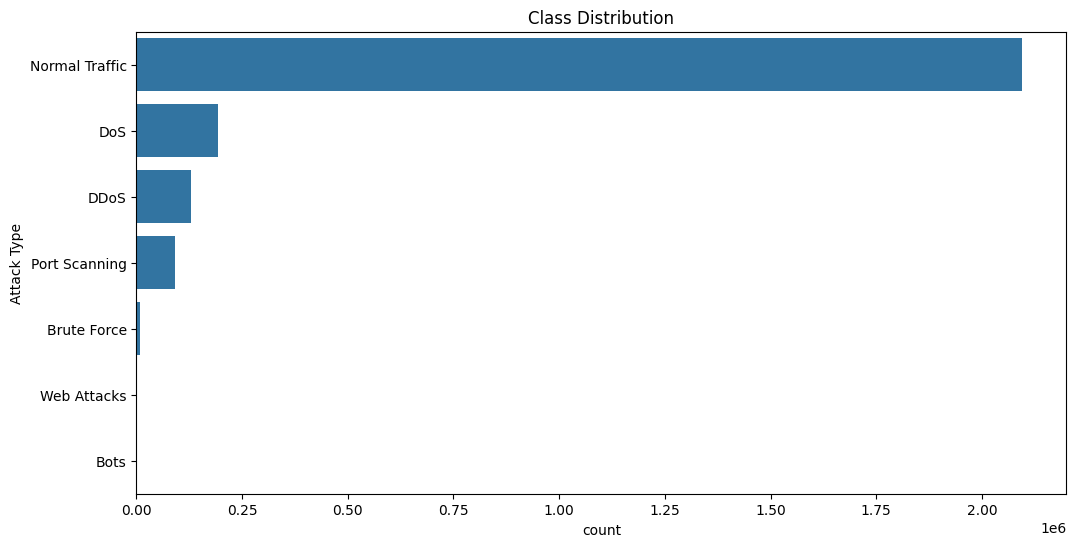

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.countplot(y=df['Attack Type'], order=df['Attack Type'].value_counts().index)
plt.title("Class Distribution")
plt.show()


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import logging
from typing import Tuple, Dict, Any
import os
from tqdm import tqdm
import time
import math

In [4]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [5]:
# Set up logging with more detailed format
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)
logger = logging.getLogger(__name__)

In [23]:
class IntrusionDetectionSystem:
    def __init__(self, config: Dict[str, Any]):
        """
        Initialize the IDS with configuration parameters.
        
        Args:
            config: Dictionary containing model configuration
        """
        self.config = config
        self.scaler = StandardScaler()
        self.label_encoder = LabelEncoder()
        
    def load_data(self, filepath: str) -> pd.DataFrame:
        """
        Load and perform initial cleaning of the CICIDS2017 dataset.
        
        Args:
            filepath: Path to the CSV file
            
        Returns:
            Cleaned DataFrame
        """
        try:
            logger.info("Loading pre-processed dataset...")
            print("\nReading CSV file...")
            df = pd.read_csv(filepath)
            
            # Log dataset information
            logger.info(f"Loaded {len(df):,} rows and {len(df.columns):,} columns")
            logger.info(f"Memory usage: {df.memory_usage().sum() / 1024**2:.2f} MB")
            
            return df
            
        except Exception as e:
            logger.error(f"Error loading data: {str(e)}")
            raise
            
    def preprocess_data(self, df: pd.DataFrame) -> Tuple[np.ndarray, np.ndarray]:
        """
        Preprocess the data for training.
        
        Args:
            df: Input DataFrame
            
        Returns:
            Tuple of (features, labels)
        """
        try:
            print("\nPreprocessing data...")
            # Separate features and labels
            X = df.drop(self.config['label_column'], axis=1)
            y = df[self.config['label_column']]
            
            # Scale features
            print("Scaling features...")
            X_scaled = self.scaler.fit_transform(X)
            
            # Encode labels
            print("Encoding labels...")
            y_encoded = self.label_encoder.fit_transform(y)
            
            # Log class distribution
            unique_labels, counts = np.unique(y_encoded, return_counts=True)
            logger.info("\nClass distribution:")
            for label, count in zip(self.label_encoder.classes_, counts):
                logger.info(f"{label}: {count:,} samples")
            
            return X_scaled, y_encoded
            
        except Exception as e:
            logger.error(f"Error preprocessing data: {str(e)}")
            raise
            
    def reshape_data(self, X: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """
        Reshape data for CNN and BiLSTM branches.
        
        Args:
            X: Input features
            
        Returns:
            Tuple of (CNN_shaped_data, LSTM_shaped_data)
        """
        try:
            print("\nReshaping data for neural networks...")
            # Reshape for CNN
            features_sqrt = math.ceil(np.sqrt(X.shape[1]))
            padding = features_sqrt ** 2 - X.shape[1]
            if padding > 0:
                X = np.pad(X, ((0, 0), (0, padding)))
            X_cnn = X.reshape(-1, features_sqrt, features_sqrt, 1)
            
            # Reshape for BiLSTM
            # Ensure that the total number of features is divisible by the number of timesteps.
            if X.shape[1] % self.config['timesteps'] != 0:
                new_total = math.ceil(X.shape[1] / self.config['timesteps']) * self.config['timesteps']
                X = np.pad(X, ((0, 0), (0, new_total - X.shape[1])))
            X_lstm = X.reshape(-1, self.config['timesteps'], X.shape[1] // self.config['timesteps'])
        
            return X_cnn, X_lstm
            
        except Exception as e:
            logger.error(f"Error reshaping data: {str(e)}")
            raise
            
    def build_model(self, input_shape_cnn: tuple, input_shape_lstm: tuple) -> tf.keras.Model:
        """
        Build the hybrid CNN-BiLSTM model.
        
        Args:
            input_shape_cnn: Shape of CNN input
            input_shape_lstm: Shape of LSTM input
            
        Returns:
            Compiled Keras model
        """
        try:
            print("\nBuilding neural network architecture...")
            # CNN branch
            cnn_input = tf.keras.layers.Input(shape=input_shape_cnn)
            x1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(cnn_input)
            x1 = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x1)
            x1 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x1)
            x1 = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x1)
            x1 = tf.keras.layers.Flatten()(x1)
            
            # BiLSTM branch
            lstm_input = tf.keras.layers.Input(shape=input_shape_lstm)
            x2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(lstm_input)
            x2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))(x2)
            
            # Combine branches
            combined = tf.keras.layers.concatenate([x1, x2])
            x = tf.keras.layers.Dense(128, activation='relu')(combined)
            x = tf.keras.layers.Dropout(0.5)(x)
            output = tf.keras.layers.Dense(len(self.label_encoder.classes_), activation='softmax')(x)
            
            model = tf.keras.Model(inputs=[cnn_input, lstm_input], outputs=output)
            
            model.compile(
                optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy']
            )
            
            # Print model summary
            print("\nModel Architecture:")
            model.summary()
            
            return model
            
        except Exception as e:
            logger.error(f"Error building model: {str(e)}")
            raise
            
    def handle_class_imbalance(self, X: np.ndarray, y: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """
        Handle class imbalance using SMOTE.
        
        Args:
            X: Features
            y: Labels
            
        Returns:
            Tuple of (balanced_features, balanced_labels)
        """
        try:
            print("\nHandling class imbalance...")
            start_time = time.time()
            
            logger.info("Original class distribution:")
            unique_labels, counts = np.unique(y, return_counts=True)
            for label, count in zip(unique_labels, counts):
                logger.info(f"Class {label}: {count:,} samples")
            
            smote = SMOTE(random_state=42)
            X_resampled, y_resampled = smote.fit_resample(X, y)
            
            logger.info("\nBalanced class distribution:")
            unique_labels, counts = np.unique(y_resampled, return_counts=True)
            for label, count in zip(unique_labels, counts):
                logger.info(f"Class {label}: {count:,} samples")
            
            duration = time.time() - start_time
            logger.info(f"Class balancing completed in {duration:.2f} seconds")
            
            return X_resampled, y_resampled
            
        except Exception as e:
            logger.error(f"Error handling class imbalance: {str(e)}")
            raise
            
    def train_and_evaluate(self, X_train: np.ndarray, y_train: np.ndarray, 
                          X_test: np.ndarray, y_test: np.ndarray) -> tf.keras.Model:
        """
        Train the model and evaluate its performance.
        
        Args:
            X_train: Training features
            y_train: Training labels
            X_test: Test features
            y_test: Test labels
            
        Returns:
            Trained model
        """
        try:
            print("\nPreparing for training...")
            # Reshape data for both branches
            X_train_cnn, X_train_lstm = self.reshape_data(X_train)
            X_test_cnn, X_test_lstm = self.reshape_data(X_test)
            
            # Build model
            model = self.build_model(X_train_cnn.shape[1:], X_train_lstm.shape[1:])
            
            # Create custom callback for progress tracking
            class TrainingProgressCallback(tf.keras.callbacks.Callback):
                def on_epoch_begin(self, epoch, logs=None):
                    print(f"\nEpoch {epoch + 1}/{self.params['epochs']}")
                
                def on_epoch_end(self, epoch, logs=None):
                    logger.info(
                        f"Epoch {epoch + 1}: loss = {logs['loss']:.4f}, "
                        f"accuracy = {logs['accuracy']:.4f}, "
                        f"val_loss = {logs['val_loss']:.4f}, "
                        f"val_accuracy = {logs['val_accuracy']:.4f}"
                    )
            
            print("\nStarting model training...")
            start_time = time.time()
            
            history = model.fit(
                [X_train_cnn, X_train_lstm],
                y_train,
                epochs=self.config['epochs'],
                batch_size=self.config['batch_size'],
                validation_split=0.2,
                callbacks=[
                    TrainingProgressCallback(),
                    tf.keras.callbacks.EarlyStopping(
                        patience=5,
                        restore_best_weights=True,
                        verbose=1
                    )
                ]
            )
            
            duration = time.time() - start_time
            logger.info(f"\nTraining completed in {duration:.2f} seconds")
            
            print("\nEvaluating model performance...")
            y_pred = model.predict([X_test_cnn, X_test_lstm], verbose=1)
            y_pred_classes = np.argmax(y_pred, axis=1)
            
            # Print evaluation metrics
            print("\nClassification Report:")
            report = classification_report(y_test, y_pred_classes,
                                        target_names=self.label_encoder.classes_)
            print(report)
            logger.info("\nDetailed classification report:\n" + report)
            
            return model
            
        except Exception as e:
            logger.error(f"Error during training and evaluation: {str(e)}")
            raise


In [24]:
def main():
    """Main function to run the IDS pipeline."""
    # Configuration
    config = {
        'data_path': 'cicids2017_cleaned.csv',
        'label_column': 'Attack Type',
        'test_size': 0.2,
        'random_state': 42,
        'timesteps': 10,
        'epochs': 50,
        'batch_size': 32
    }
    
    try:
        print("\n=== Starting Intrusion Detection System Training ===")
        start_time = time.time()
        
        # Initialize IDS
        ids = IntrusionDetectionSystem(config)
        
        # Load and preprocess data
        df = ids.load_data(config['data_path'])
        X, y = ids.preprocess_data(df)
        
        # Handle class imbalance
        print("\nChecking class distribution...")
        unique_labels, counts = np.unique(y, return_counts=True)
        imbalanced = max(counts) / min(counts) > 10  # Check if imbalance ratio > 10

        if imbalanced:
            print("Detected significant class imbalance. Applying SMOTE...")
            X_balanced, y_balanced = ids.handle_class_imbalance(X, y)
        else:
            print("Class distribution is acceptable. Proceeding without balancing.")
            X_balanced, y_balanced = X, y
        
        # Split data
        print("\nSplitting data into training and test sets...")
        X_train, X_test, y_train, y_test = train_test_split(
            X_balanced, y_balanced,
            test_size=config['test_size'],
            random_state=config['random_state'],
            stratify=y_balanced  # Ensure balanced split
        )
        logger.info(f"Training set size: {len(X_train):,} samples")
        logger.info(f"Test set size: {len(X_test):,} samples")
        
        # Train and evaluate model
        model = ids.train_and_evaluate(X_train, y_train, X_test, y_test)
        
        # Save model
        print("\nSaving model...")
        model.save('ids_model.h5')
        logger.info("Model saved successfully as 'ids_model.h5'")
        
        total_duration = time.time() - start_time
        logger.info(f"\nTotal execution time: {total_duration:.2f} seconds")
        print("\n=== Training Complete ===")
        
    except Exception as e:
        logger.error(f"Error in main function: {str(e)}")
        raise

if __name__ == "__main__":
    main()

2025-02-23 16:59:19 - INFO - Loading pre-processed dataset...



=== Starting Intrusion Detection System Training ===

Reading CSV file...


2025-02-23 16:59:25 - INFO - Loaded 2,520,751 rows and 53 columns
2025-02-23 16:59:25 - INFO - Memory usage: 1019.29 MB



Preprocessing data...
Scaling features...
Encoding labels...


2025-02-23 16:59:28 - INFO - 
Class distribution:
2025-02-23 16:59:28 - INFO - Bots: 1,948 samples
2025-02-23 16:59:28 - INFO - Brute Force: 9,150 samples
2025-02-23 16:59:28 - INFO - DDoS: 128,014 samples
2025-02-23 16:59:28 - INFO - DoS: 193,745 samples
2025-02-23 16:59:28 - INFO - Normal Traffic: 2,095,057 samples
2025-02-23 16:59:28 - INFO - Port Scanning: 90,694 samples
2025-02-23 16:59:28 - INFO - Web Attacks: 2,143 samples
2025-02-23 16:59:28 - INFO - Original class distribution:
2025-02-23 16:59:28 - INFO - Class 0: 1,948 samples
2025-02-23 16:59:28 - INFO - Class 1: 9,150 samples
2025-02-23 16:59:28 - INFO - Class 2: 128,014 samples
2025-02-23 16:59:28 - INFO - Class 3: 193,745 samples
2025-02-23 16:59:28 - INFO - Class 4: 2,095,057 samples
2025-02-23 16:59:28 - INFO - Class 5: 90,694 samples
2025-02-23 16:59:28 - INFO - Class 6: 2,143 samples



Checking class distribution...
Detected significant class imbalance. Applying SMOTE...

Handling class imbalance...


2025-02-23 17:00:27 - INFO - 
Balanced class distribution:
2025-02-23 17:00:27 - INFO - Class 0: 2,095,057 samples
2025-02-23 17:00:27 - INFO - Class 1: 2,095,057 samples
2025-02-23 17:00:27 - INFO - Class 2: 2,095,057 samples
2025-02-23 17:00:27 - INFO - Class 3: 2,095,057 samples
2025-02-23 17:00:27 - INFO - Class 4: 2,095,057 samples
2025-02-23 17:00:27 - INFO - Class 5: 2,095,057 samples
2025-02-23 17:00:27 - INFO - Class 6: 2,095,057 samples
2025-02-23 17:00:27 - INFO - Class balancing completed in 59.27 seconds



Splitting data into training and test sets...


2025-02-23 17:00:33 - INFO - Training set size: 11,732,319 samples
2025-02-23 17:00:33 - INFO - Test set size: 2,933,080 samples



Preparing for training...

Reshaping data for neural networks...

Reshaping data for neural networks...

Building neural network architecture...

Model Architecture:
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 8, 8, 1)]    0           []                               
                                                                                                  
 conv2d_2 (Conv2D)              (None, 8, 8, 32)     320         ['input_2[0][0]']                
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 4, 4, 32)    0           ['conv2d_2[0][0]']               
                                                                                                  
 conv2d_3 (Conv2D)        

2025-02-23 17:42:07 - ERROR - Error during training and evaluation: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.
2025-02-23 17:42:07 - ERROR - Error in main function: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.


InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.